In [4]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
%matplotlib widget
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
import torch
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import torchCompactRadius

In [5]:
# import torchCompactRadius_cpu

In [6]:
import numpy as np
import torchCompactRadius as tcr
from torchCompactRadius import radiusSearch, volumeToSupport
from torchCompactRadius.util import countUniqueEntries
# from torchCompactRadius.radiusNaive import radiusNaive, radiusNaiveFixed
# from torchCompactRadius.cppWrapper import neighborSearchSmall, neighborSearchSmallFixed
import platform
# import pandas as pd
import time
# from tqdm.autonotebook import tqdm
import copy
# import seaborn as sns

def generateNeighborTestData(nx, targetNumNeighbors, dim, maxDomain_0, periodic, device):


    minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
    maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
    maxDomain[0] = maxDomain_0
    periodicity = torch.tensor([periodic] * dim, device = device, dtype = torch.bool)

    extent = maxDomain - minDomain
    shortExtent = torch.min(extent, dim = 0)[0].item()
    dx = (shortExtent / nx)
    ny = int(1 // dx)
    h = volumeToSupport(dx**dim, targetNumNeighbors, dim)
    dy = dx / 1.5
    ny = int(1 // dy)

    # print(f"dx = {dx}, dy = {dy}, h = {h}")
    # print(f"nx = {nx}, ny = {ny}")
    # print(f"minDomain = {minDomain}, maxDomain = {maxDomain}")
    # print(f"periodicity = {periodicity}")
    # print(f"dim = {dim}")
    # print(f"device = {device}")
    # print(f"maxDomain_0 = {maxDomain_0}")
    # print(f"targetNumNeighbors = {targetNumNeighbors}")
    

    positions = []
    for d in range(dim):
        positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
    grid = torch.meshgrid(*positions, indexing = 'xy')
    positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    supports = torch.ones(positions.shape[0], device = device) * h
    ypositions = []
    for d in range(dim):
        ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
    grid = torch.meshgrid(*ypositions, indexing = 'xy')
    y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    ySupport = torch.ones(y.shape[0], device = device) * volumeToSupport(dy**dim, targetNumNeighbors, dim)
    return (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, positions.shape[0]

def test_ij(i, j, y, positions, periodic):
    try:
        if y.shape == positions.shape and torch.all(y == positions):
            if torch.any(periodic):
                assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
                assert i.shape[0] == 46080, f'i.shape[0] = {i.shape[0]} != 11520'
                assert j.shape[0] == 46080, f'i.shape[0] = {j.shape[0]} != 11520'
                ii, ni = countUniqueEntries(i, y)
                jj, nj = countUniqueEntries(j, positions)
                assert ni.min() == ni.max(), f'ni.min() = {ni.min()} != ni.max() = {ni.max()}'
                assert ni.min() == 45, f'ni.min() = {ni.min()} != 45'
                print('✅', end = '')
            else:
                assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
                assert i.shape[0] == 41580, f'i.shape[0] = {i.shape[0]} != 41580'
                assert j.shape[0] == 41580, f'i.shape[0] = {j.shape[0]} != 41580'
                ii, ni = countUniqueEntries(i, y)
                jj, nj = countUniqueEntries(j, positions)
                assert ni.min() != ni.max(), f'ni.min() = {ni.min()} == ni.max() = {ni.max()}'
                assert nj.min() != nj.max(), f'nj.min() = {nj.min()} == nj.max() = {nj.max()}'

                assert ni.min() == 15, f'ni.min() = {ni.min()} != 15'
                assert ni.max() == 45, f'ni.min() = {ni.min()} != 45'
                print('✅', end = '')
        else:
            assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
            assert i.shape[0] == 11520, f'i.shape[0] = {i.shape[0]} != 11520'
            assert j.shape[0] == 11520, f'i.shape[0] = {j.shape[0]} != 11520'
            ii, ni = countUniqueEntries(i, y)
            jj, nj = countUniqueEntries(j, positions)
            assert ni.min() == ni.max(), f'ni.min() = {ni.min()} != ni.max() = {ni.max()}'
            assert ni.min() == 45, f'ni.min() = {ni.min()} != 45'
            print('✅', end = '')
    except AssertionError as e:
        print('❌', end = '')



In [147]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2
periodic = False
(y, x), (ySupport, xSupport), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)
h = ySupport[0].cpu().item()

from torchCompactRadius.util import DomainDescription, PointCloud

minDomain *= 2
maxDomain *= 2
domainDescription = DomainDescription(minDomain, maxDomain, periodicity, dim)

pointCloudX = PointCloud(x, xSupport)
pointCloudY = PointCloud(y, ySupport)

# pointCloudX = PointCloud(x, None)
# pointCloudY = PointCloud(y, None)

In [148]:
# i, j = radiusSearch(pointCloudY, pointCloudX, supportOverride= h, algorithm = 'compact', domain = domainDescription, verbose = True)
# test_ij(i, j, y, x, periodic)
# i, j = radiusSearch(pointCloudX, pointCloudY, supportOverride= h, algorithm = 'compact', domain = domainDescription)
# test_ij(j, i, y, x, periodic)

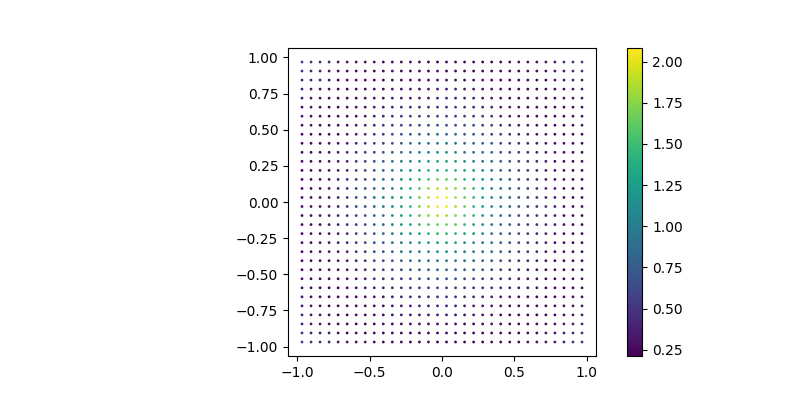

In [149]:
pointCloudX.supports = xSupport + torch.randn_like(xSupport) * xSupport.max() / 16 + (1 - torch.linalg.norm(x, dim = -1))**2 * xSupport.max() * 8
pointCloudY.supports = ySupport + torch.randn_like(ySupport) * ySupport.max() / 16 + (1 - torch.linalg.norm(y, dim = -1))**2 * xSupport.max() * 4
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze=False)

sc = axis[0,0].scatter(x[:,0], x[:,1], s = 1, c = pointCloudX.supports.cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])

axis[0,0].set_aspect('equal')

In [150]:
def computeCellResolution(domain, hMin):
    qExtent = domain.max - domain.min
    qCells = qExtent / hMin
    
    qCells = (2 ** torch.floor(torch.log2(qCells))).int()
    
    # print(qCells)
    
    hCell = qExtent / qCells
    print(hCell, hMin)
    
    hCell = hCell.max()
    
    return hCell, qCells
    
hCell, qCells = computeCellResolution(domainDescription, h)

tensor([0.2500, 0.2500]) 0.16622595489025116


hMin = 0.21159598231315613, hMax = 2.082659959793091, hRatio = 9.842625256990052
levels = 3
level = 0, h = 0.25, qCells = tensor([16., 16.])
level = 1, h = 0.5, qCells = tensor([8., 8.])
level = 2, h = 1.0, qCells = tensor([4., 4.])
levels = 3
level.min() = 0, level.max() = 2


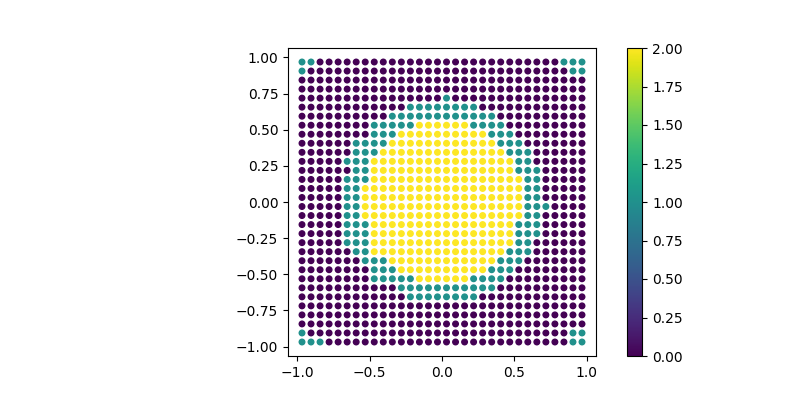

In [151]:
hMin = pointCloudX.supports.min().cpu().item()
hMax = pointCloudX.supports.max().cpu().item()

hRatio = hMax / hMin
print(f'hMin = {hMin}, hMax = {hMax}, hRatio = {hRatio}')
levels = int(np.floor(np.log2(hRatio)))
print(f'levels = {levels}')

levelResolutions = []
for i in range(levels):
    if (qCells / 2**i).min() <= 1:
        break
    print(f'level = {i}, h = {hCell * 2**i}, qCells = {qCells / 2**i}')
    levelResolutions.append((i, hCell * 2**i, qCells / 2**i))

levels = len(levelResolutions)
print(f'levels = {levels}')

level = pointCloudX.supports / hMin
level = torch.floor(level)
level = torch.clamp(level, 0, levels)
level = level.int() - 1

print(f'level.min() = {level.min()}, level.max() = {level.max()}')

fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze=False)
sc = axis[0,0].scatter(x[:,0], x[:,1], s = 16, c = level.cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])
axis[0,0].set_aspect('equal')

In [152]:
def spread2(w : torch.Tensor):
    w &= 0x00000000001fffff
    w = (w | w << 32) & 0x001f00000000ffff
    w = (w | w << 16) & 0x001f0000ff0000ff
    w = (w | w <<  8) & 0x010f00f00f00f00f
    w = (w | w <<  4) & 0x10c30c30c30c30c3
    w = (w | w <<  2) & 0x1249249249249249
    return w
def compact2(w : torch.Tensor):
    w &= 0x1249249249249249
    w = (w ^ (w >> 2))  & 0x30c30c30c30c30c3
    w = (w ^ (w >> 4))  & 0xf00f00f00f00f00f
    w = (w ^ (w >> 8))  & 0x00ff0000ff0000ff
    w = (w ^ (w >> 16)) & 0x00ff00000000ffff
    w = (w ^ (w >> 32)) & 0x00000000001fffff
    return w
def Z_encode3D(x : torch.Tensor, y : torch.Tensor, z : torch.Tensor):
    return ((spread2(x.to(torch.int64))) | (spread2(y.to(torch.int64)) << 1) | (spread2(z.to(torch.int64)) << 2))
def Z_decode3D(Z_code):
    x = compact2(Z_code)
    y = compact2(Z_code >> 1)
    z = compact2(Z_code >> 2)
    return x, y, z

def spread1(x: torch.Tensor):
    x &= 0x00000000ffffffff
    x = (x | (x << 16)) & 0x0000FFFF0000FFFF
    x = (x | (x << 8)) & 0x00FF00FF00FF00FF
    x = (x | (x << 4)) & 0x0F0F0F0F0F0F0F0F
    x = (x | (x << 2)) & 0x3333333333333333
    x = (x | (x << 1)) & 0x5555555555555555
    return x
def compact1(x: torch.Tensor):
    x = x & 0x5555555555555555
    x = (x | (x >> 1))  & 0x3333333333333333
    x = (x | (x >> 2))  & 0x0F0F0F0F0F0F0F0F
    x = (x | (x >> 4))  & 0x00FF00FF00FF00FF
    x = (x | (x >> 8))  & 0x0000FFFF0000FFFF
    x = (x | (x >> 16)) & 0x00000000FFFFFFFF
    return x
def Z_encode2D(x : torch.Tensor, y : torch.Tensor):
    return ((spread1(x.to(torch.int64))) | (spread1(y.to(torch.int64)) << 1))
def Z_decode2D(Z_code):
    x = compact1(Z_code)
    y = compact1(Z_code >> 1)
    return x, y

[tensor([ 48,  48,  48,  ..., 207, 207, 207], dtype=torch.int32), tensor([12, 12, 12,  ..., 51, 51, 51], dtype=torch.int32), tensor([ 3,  3,  3,  ..., 12, 12, 12], dtype=torch.int32)]


(-2.0, 2.0)

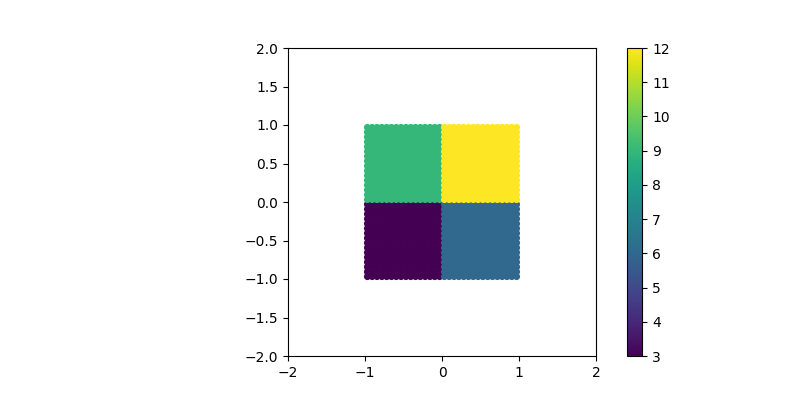

In [153]:
xi = ((x[:,0] - domainDescription.min[0]) / hCell).int()
yi = ((x[:,1] - domainDescription.min[1]) / hCell).int()
# mort = Z_encode2D(xi, yi)

def getMortonCodes(x, y, hCell, domainDescription, levels):
    xi = ((x - domainDescription.min[0]) / hCell).int()
    yi = ((y - domainDescription.min[1]) / hCell).int()
    morton = Z_encode2D(xi, yi)
    
    codes = []
    for level in range(levels):
        codes.append((morton >> level * 2).int())
    return codes
codes = getMortonCodes(x[:,0], x[:,1], hCell, domainDescription, levels)

print(codes)

xi_, yi_ = Z_decode2D(codes[0])
assert torch.all(xi == xi_)
assert torch.all(yi == yi_)

fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze=False)
sc = axis[0,0].scatter(x[:,0], x[:,1], s = 16, c = codes[-1].cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])
axis[0,0].set_aspect('equal')
axis[0,0].set_xlim(minDomain[0], maxDomain[0])
axis[0,0].set_ylim(minDomain[1], maxDomain[1])

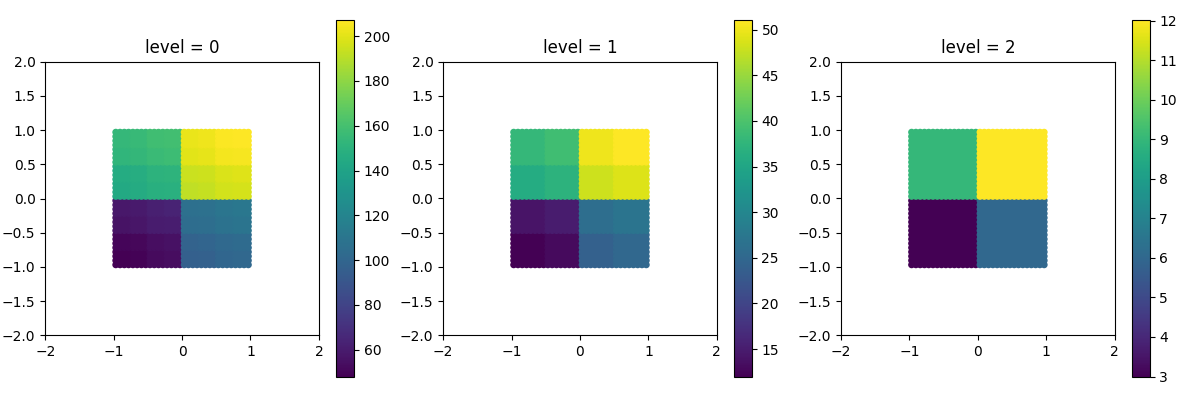

In [156]:
sortingIndices = torch.argsort(codes[0])

sortedPositions = x[sortingIndices]
sortedCodes = [code[sortingIndices] for code in codes]

fig, axis = plt.subplots(1,len(sortedCodes), figsize = (len(sortedCodes)* 4,4), squeeze=False)
for i, code in enumerate(sortedCodes):
    sc = axis[0,i].scatter(sortedPositions[:,0], sortedPositions[:,1], s = 16, c = code.cpu().numpy())
    fig.colorbar(sc, ax = axis[0,i])
    axis[0,i].set_aspect('equal')
    axis[0,i].set_title(f'level = {i}')
    axis[0,i].set_xlim(minDomain[0], maxDomain[0])
    axis[0,i].set_ylim(minDomain[1], maxDomain[1])
fig.tight_layout()

In [ ]:
# print(levelResolutions[0])

(0, tensor(0.2500), tensor([16., 16.]))


In [246]:
from dataclasses import dataclass
from typing import Optional

@dataclass(slots = True)
class CellData:
    cellBegin:      torch.Tensor
    cellEnd:        torch.Tensor
    cellIndices:    torch.Tensor
    cellCounters:   torch.Tensor
    cellLevel:      torch.Tensor
    
    levelIndex: Optional[int]
    levelResolution: Optional[torch.Tensor]
    levelExtent: Optional[torch.Tensor]

def linearToMorton(linearIndex, gridResolution):
    return Z_encode2D(linearIndex % gridResolution[0], linearIndex // gridResolution[0])
def mortonToLinear(mortonIndex, gridResolution):
    return Z_decode2D(mortonIndex)[0] + Z_decode2D(mortonIndex)[1] * gridResolution[0]

def buildDenseCellData(codes, level):
    cellIndices, cellCounters = torch.unique_consecutive(codes, return_counts=True, return_inverse=False)
    cellCounters = cellCounters.to(torch.int32)
    
    cumCell = torch.hstack((torch.tensor([0], device = cellIndices.device, dtype=cellCounters.dtype),torch.cumsum(cellCounters,dim=0))).to(torch.int32)
    cellGridIndices = codes[cumCell[:-1]]
    
    # print('cellGridIndices : ', cellGridIndices.shape)
    
    # print(level[2].int())
    # print(torch.prod(level[2].int()).cpu().item())
    
    denseCellBegins = torch.ones(torch.prod(level[2].int()).cpu().item(), device = cellIndices.device, dtype = cellIndices.dtype) * -1
    denseCellEnds = torch.ones_like(denseCellBegins) * -1
    denseCellBegins[cellGridIndices] = cumCell[:-1]
    denseCellEnds[cellGridIndices] = cumCell[1:]
    
    linearIndices = torch.arange(torch.prod(level[2].int()).cpu().item(), device = cellIndices.device)
    convertedIndices = linearToMorton(linearIndices, level[2].int())#.view(level[2][0].int().cpu().item(), level[2][1].int().cpu().item()).mT.flatten()
    
    linearIndices = mortonToLinear(cellGridIndices, level[2].int())
    
    denseCellIndices = torch.zeros_like(convertedIndices)
    denseCellIndices[convertedIndices] = convertedIndices
    denseCellIndices[cellGridIndices] = cellGridIndices.to(denseCellIndices.dtype)
    cellLevel = torch.ones_like(cellIndices) * level[0]
    
    return CellData(denseCellBegins, denseCellEnds, denseCellIndices, denseCellEnds - denseCellBegins, cellLevel, level[0], level[1], level[2])

def buildSparseCellData(codes, level):
    cellIndices, cellCounters = torch.unique_consecutive(codes, return_counts=True, return_inverse=False)
    cellCounters = cellCounters.to(torch.int32)
    
    cumCell = torch.hstack((torch.tensor([0], device = cellIndices.device, dtype=cellCounters.dtype),torch.cumsum(cellCounters,dim=0))).to(torch.int32)
    cellGridIndices = codes[cumCell[:-1]]
    
    # print('cellGridIndices : ', cellGridIndices.shape)
    
    # print(level[2].int())
    # print(torch.prod(level[2].int()).cpu().item())
    
    cellBegins = cumCell[:-1]
    cellEnds = cumCell[1:]
    cellIndices = cellGridIndices
    cellLevel = torch.ones_like(cellIndices) * level[0]
    
    return CellData(cellBegins, cellEnds, cellIndices, cellEnds - cellBegins, cellLevel, level[0], level[1], level[2])


cells = []

for il, level in enumerate(levelResolutions):
    cells.append(buildSparseCellData(sortedCodes[il], level))
    

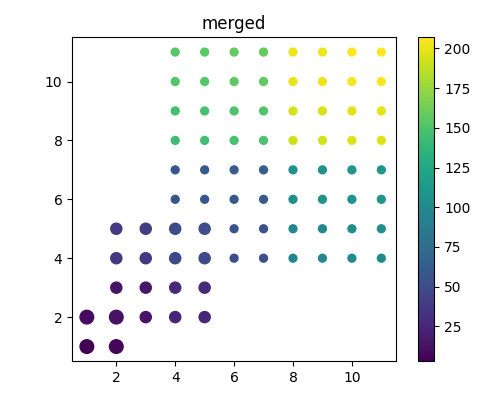

In [253]:
def mergeCells(cells):
    cellBegins, cellEnds, cellIndices, cellCounters, cellLevel = [], [], [], [], []
    offset = 0
    baseExtent = torch.prod(levelResolutions[0][2].int()).cpu().item()
    
    for cell in cells:
        cellBegins.append(cell.cellBegin)
        cellEnds.append(cell.cellEnd)
        cellIndices.append(cell.cellIndices)
        cellCounters.append(cell.cellCounters)
        cellLevel.append(cell.cellLevel)
        offset += torch.prod(cell.levelExtent).cpu().item()
    cellBegins = torch.hstack(cellBegins)
    cellEnds = torch.hstack(cellEnds)
    cellIndices = torch.hstack(cellIndices)
    cellCounters = torch.hstack(cellCounters)
    cellLevel = torch.hstack(cellLevel)
    
    return CellData(cellBegins, cellEnds, cellIndices, cellCounters, cellLevel, None, None, None)

mergedCells = mergeCells(cells)

fig, axis = plt.subplots(1, 1, figsize = (5, 4), squeeze=False)
baseExtent = torch.prod(levelResolutions[0][2].int()).cpu().item()
cellIndices = mergedCells.cellIndices# - mergedCells.cellLevel * baseExtent
decodedCellX, decodedCellY = Z_decode2D(cellIndices)
cellCounters = mergedCells.cellCounters
sc = axis[0,0].scatter(decodedCellX.cpu().numpy(), decodedCellY.cpu().numpy(), s = 32 * ( 1 + mergedCells.cellLevel.cpu().numpy()), c = cellIndices.cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])
axis[0,0].set_aspect('equal')
axis[0,0].set_title(f'merged')

fig.tight_layout()

In [254]:
from torchCompactRadius.util import hashCellIndices_cpp

In [255]:
@dataclass(slots = True)
class HashMapData:
    hashMapOffset: torch.Tensor
    hashMapOccupancy: torch.Tensor
    hashMapIndices: torch.Tensor
    
    hashedIndices: torch.Tensor
    sortedCells: torch.Tensor

def hashMortonCodes(codes, hashMapLength):
    decodedX, decodedY = Z_decode2D(codes)
    decoded = torch.stack((decodedX, decodedY), dim = -1)
    return hashCellIndices_cpp(decoded, hashMapLength)

def buildHashMap(cellList, hashMapLength):
    hashedIndices = hashMortonCodes(cellList.cellIndices, hashMapLength)
    hashIndexSorting = torch.argsort(hashedIndices)
    hashMap, hashMapCounters = torch.unique_consecutive(hashedIndices[hashIndexSorting], return_counts=True, return_inverse=False)
    hashMapCounters = hashMapCounters.to(torch.int32)

    sortedCells = torch.arange(hashIndexSorting.shape[0], device = hashIndexSorting.device)[hashIndexSorting]

    cumhash = torch.hstack((torch.tensor([0], device = hashMap.device, dtype=hashMapCounters.dtype),torch.cumsum(hashMapCounters,dim=0))).to(torch.int32)

    hashMapOffset = torch.ones(hashMapLength, device=hashedIndices.device, dtype = torch.int32) * -1
    hashMapOccupancy = torch.zeros(hashMapLength, device=hashedIndices.device, dtype = torch.int32)
    hashMapIndices = torch.ones(hashMapLength, device=hashedIndices.device, dtype = torch.int32) * -1

    hashMapOffset[hashMap] = cumhash[:-1]
    hashMapOccupancy[hashMap] = cumhash[1:] - cumhash[:-1]
    hashMapIndices[hashMap] = hashMap
    
    return HashMapData(hashMapOffset, hashMapOccupancy, hashMapIndices, hashedIndices, sortedCells)

hashMapLength = 32
hashMapData = buildHashMap(cells[0], hashMapLength)

for h in range(hashMapLength):
    print(f'hash = {h}, offset = {hashMapData.hashMapOffset[h]}, occupancy = {hashMapData.hashMapOccupancy[h]}')
    for i in range(hashMapData.hashMapOffset[h], hashMapData.hashMapOffset[h] + hashMapData.hashMapOccupancy[h]):
        print(f'    cell = {hashMapData.sortedCells[i]}, morton = {cells[0].cellIndices[hashMapData.sortedCells[i]]}, hash = {hashMapData.hashedIndices[hashMapData.sortedCells[i]]}')

hash = 0, offset = 0, occupancy = 3
    cell = 48, morton = 192, hash = 0
    cell = 47, morton = 159, hash = 0
    cell = 19, morton = 99, hash = 0
hash = 1, offset = 3, occupancy = 3
    cell = 17, morton = 97, hash = 1
    cell = 26, morton = 106, hash = 1
    cell = 45, morton = 157, hash = 1
hash = 2, offset = 6, occupancy = 2
    cell = 39, morton = 151, hash = 2
    cell = 24, morton = 104, hash = 2
hash = 3, offset = 8, occupancy = 3
    cell = 46, morton = 158, hash = 3
    cell = 37, morton = 149, hash = 3
    cell = 18, morton = 98, hash = 3
hash = 4, offset = 11, occupancy = 3
    cell = 15, morton = 63, hash = 4
    cell = 16, morton = 96, hash = 4
    cell = 44, morton = 156, hash = 4
hash = 5, offset = 14, occupancy = 2
    cell = 38, morton = 150, hash = 5
    cell = 13, morton = 61, hash = 5
hash = 6, offset = 16, occupancy = 3
    cell = 7, morton = 55, hash = 6
    cell = 36, morton = 148, hash = 6
    cell = 43, morton = 155, hash = 6
hash = 7, offset = 19, occupanc

In [257]:
mergedHashMapData = buildHashMap(mergedCells, hashMapLength)
for h in range(hashMapLength):
    print(f'hash = {h}, offset = {mergedHashMapData.hashMapOffset[h]}, occupancy = {mergedHashMapData.hashMapOccupancy[h]}')
    for i in range(mergedHashMapData.hashMapOffset[h], mergedHashMapData.hashMapOffset[h] + mergedHashMapData.hashMapOccupancy[h]):
        print(f'    cell = {mergedHashMapData.sortedCells[i]}, level = {mergedCells.cellLevel[mergedHashMapData.sortedCells[i]]} morton = {mergedCells.cellIndices[mergedHashMapData.sortedCells[i]]}, hash = {mergedHashMapData.hashedIndices[mergedHashMapData.sortedCells[i]]}')

hash = 0, offset = 0, occupancy = 3
    cell = 19, level = 0 morton = 99, hash = 0
    cell = 47, level = 0 morton = 159, hash = 0
    cell = 48, level = 0 morton = 192, hash = 0
hash = 1, offset = 3, occupancy = 3
    cell = 45, level = 0 morton = 157, hash = 1
    cell = 17, level = 0 morton = 97, hash = 1
    cell = 26, level = 0 morton = 106, hash = 1
hash = 2, offset = 6, occupancy = 2
    cell = 24, level = 0 morton = 104, hash = 2
    cell = 39, level = 0 morton = 151, hash = 2
hash = 3, offset = 8, occupancy = 3
    cell = 46, level = 0 morton = 158, hash = 3
    cell = 18, level = 0 morton = 98, hash = 3
    cell = 37, level = 0 morton = 149, hash = 3
hash = 4, offset = 11, occupancy = 3
    cell = 44, level = 0 morton = 156, hash = 4
    cell = 15, level = 0 morton = 63, hash = 4
    cell = 16, level = 0 morton = 96, hash = 4
hash = 5, offset = 14, occupancy = 2
    cell = 38, level = 0 morton = 150, hash = 5
    cell = 13, level = 0 morton = 61, hash = 5
hash = 6, offset = 1

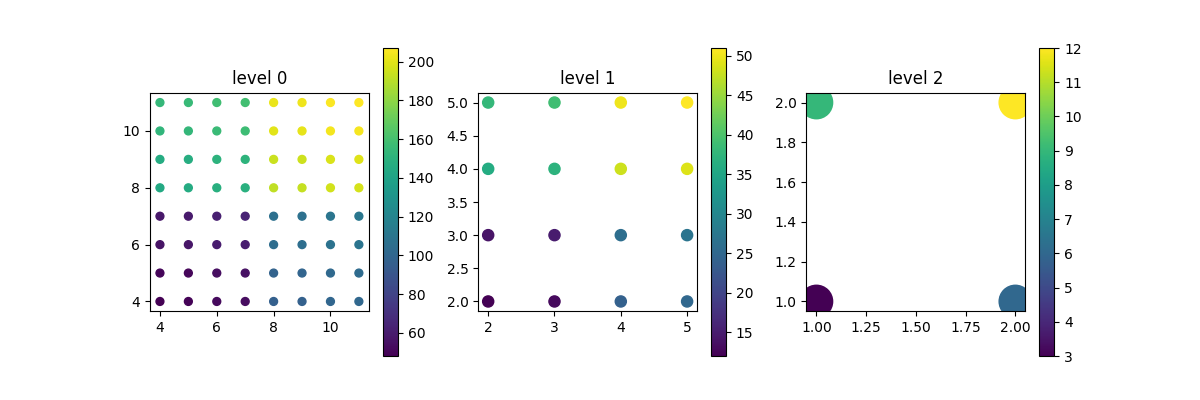

In [217]:
fig, axis = plt.subplots(1, len(cells), figsize = (4 * len(cells), 4), squeeze=False)
for i, cell in enumerate(cells):
    cellIndices = cell.cellIndices#.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
    # cellBegins = cell.cellBegin.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
    # cellEnds = cell.cellEnd.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
    cellCounters = cell.cellCounters#.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
    
    decodedCellX, decodedCellY = Z_decode2D(cellIndices)
    # print(decodedCellY, decodedCellX)
    
    
    # sc = axis[0,i].imshow(cellBegins.cpu().numpy(), cmap = 'berlin')
    sc = axis[0,i].scatter(decodedCellX.cpu().numpy(), decodedCellY.cpu().numpy(), s = 32 * (i**4 + 1), c = cellIndices.cpu().numpy())
    fig.colorbar(sc, ax = axis[0,i])
    axis[0,i].set_aspect('equal')
    axis[0,i].set_title(f'level {i}')

In [11]:

cooAdjacency = radiusSearch(pointCloudX, pointCloudY, algorithm = 'compact', domain = domainDescription, mode = 'symmetric')
print(cooAdjacency)


# print(i,j)

# cooNeighbors = SparseCOO(i, j, x.shape[0], y.shape[0])

# csrNeighbors = coo_to_csr(cooNeighbors, isSorted=False)
# cooNeighbors2 = csr_to_coo(csrNeighbors)

SparseCOO(row=tensor([167, 168, 168,  ..., 855, 856, 856]), col=tensor([  0,   1,   0,  ..., 573, 575, 574]), numRows=1024, numCols=576)


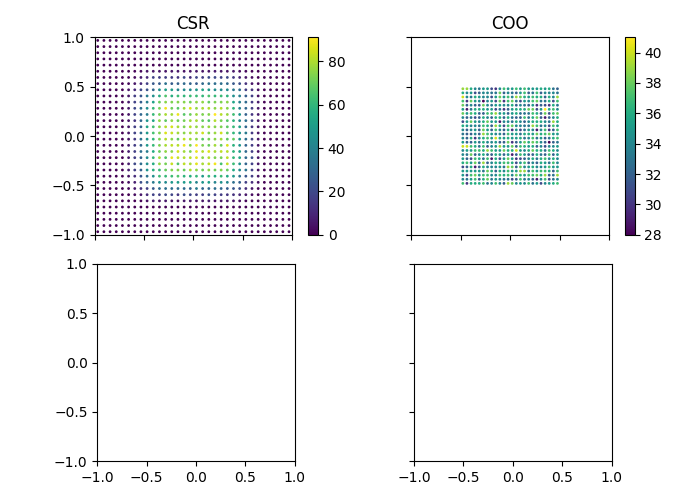

In [ ]:

_, numNeighborsI = countUniqueEntries(cooAdjacency.row, x)
_, numNeighborsJ = countUniqueEntries(cooAdjacency.col, y)

fig, ax = plt.subplots(2, 2, figsize = (7, 5), squeeze=False, sharey = True, sharex=True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)


pointCloudY2 = PointCloud(y, ySupport * 2)

sc = ax[0,0].scatter(pointCloudX.positions[:,0], pointCloudX.positions[:,1], cmap = 'viridis', c= numNeighborsI, s = 1)
plt.colorbar(sc, ax = ax[0,0])
ax[0,0].set_title('CSR')

sc = ax[0,1].scatter(pointCloudY.positions[:,0], pointCloudY.positions[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
plt.colorbar(sc, ax = ax[0,1])
ax[0,1].set_title('COO')


fig.tight_layout()

In [19]:
from sphMath.kernels import SPHKernel
from sphMath.kernels import getSPHKernel
from typing import Union, Tuple, Optional
from sphMath.sphOperations.shared import get_i, get_j, mod_distance, getSupport, scatter_sum, product

wrappedKernel = getSPHKernel('Wendland4')

In [32]:
positions = (pointCloudX.positions, pointCloudY.positions)
supports = (pointCloudX.supports, pointCloudY.supports)
i = cooAdjacency.row
j = cooAdjacency.col

periodicity = domainDescription.periodicity
minExtent = domainDescription.min
maxExtent = domainDescription.max

x_ij = mod_distance(get_i(positions, i), get_j(positions, j), periodicity, minExtent, maxExtent)

h_ij = getSupport(supports, i, j, mode = 'symmetric')


gradW_ij = wrappedKernel.jacobian(x_ij, h_ij)
# print(f'gradW_ij: {gradW_ij.min()}, {gradW_ij.max()}, {gradW_ij.mean()}')

W_ij = wrappedKernel.eval(x_ij, h_ij)
print(W_ij.min(), W_ij.max(), W_ij.mean())

tensor(2.2181e-32) tensor(78.4986) tensor(7.3461)


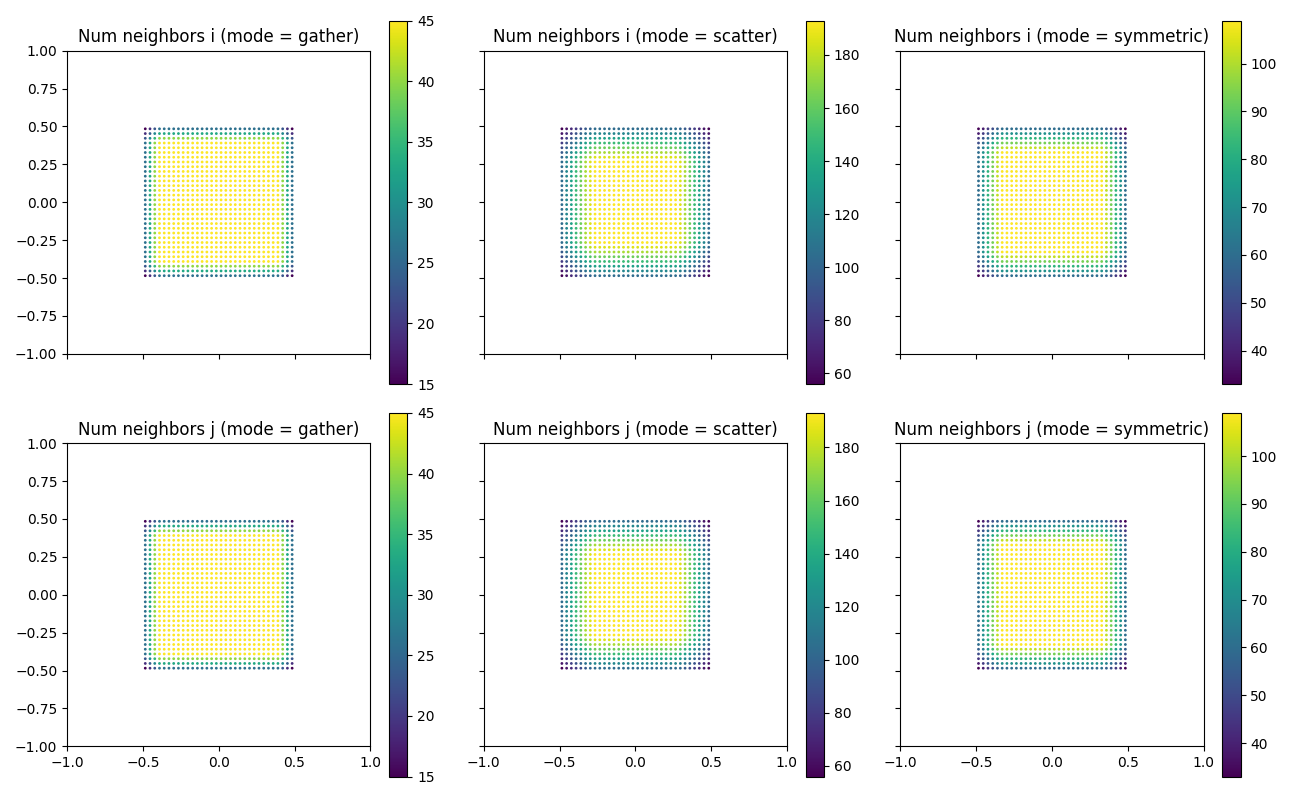

In [27]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 3, figsize = (13, 8), squeeze=False, sharey = True, sharex=True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)


pointCloudY2 = PointCloud(y, ySupport * 2)

for mi, mode in enumerate(['gather', 'scatter', 'symmetric']):

    i, j = radiusSearch(pointCloudY, pointCloudY2, algorithm = 'small', domain = domainDescription, mode = mode, verbose = False)
    jj, numNeighborsJ = countUniqueEntries(j, y)
    ii, numNeighborsI = countUniqueEntries(i, y)

    sc = ax[0,mi].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsI, s = 1)
    plt.colorbar(sc, ax = ax[0,mi])
    sc = ax[1,mi].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
    plt.colorbar(sc, ax = ax[1,mi])

    ax[0,mi].set_title(f'Num neighbors i (mode = {mode})')
    ax[1,mi].set_title(f'Num neighbors j (mode = {mode})')


fig.tight_layout()

torch.Size([28672]) torch.Size([28672]) tensor([167, 168, 168,  ..., 855, 855, 856]) tensor([167, 168, 168,  ..., 855, 855, 856])
torch.Size([28672]) torch.Size([28672]) tensor([   0,    1,    0,  ..., 1022, 1021, 1023]) tensor([   0,    1,    0,  ..., 1022, 1021, 1023])


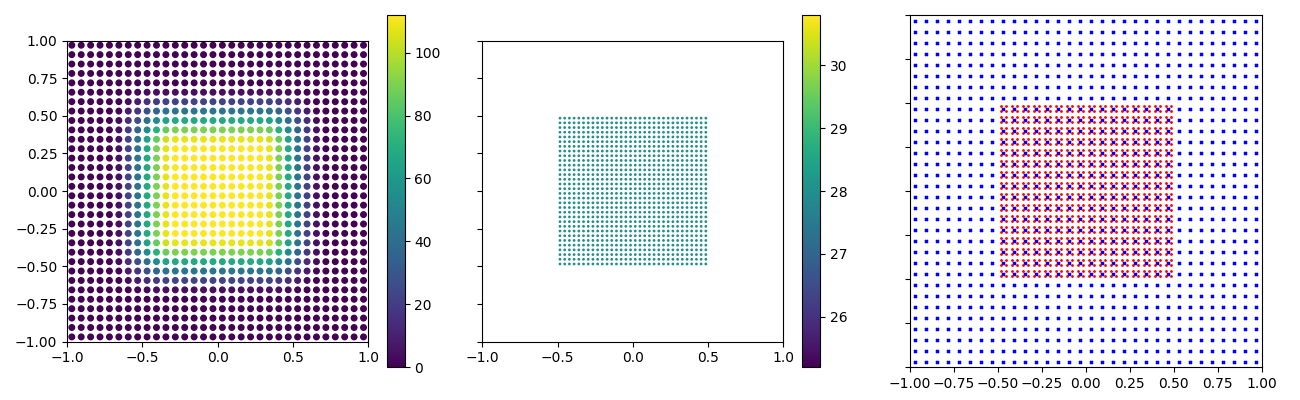

In [ ]:
from torchCompactRadius.compactHashing.datastructure import buildDataStructure
from torchCompactRadius import neighborSearchExisting
    
compactHashMap = buildDataStructure(pointCloudY, max(pointCloudX.supports.max().item(), pointCloudY.supports.max().item()), domainDescription, hashMapLength=4096)
i2,j2 = neighborSearchExisting(pointCloudX, compactHashMap, mode = 'symmetric')


# i, j, structure = radiusSearch(x, y, fixedSupport= torch.tensor(h, dtype = x.dtype, device = x.device), algorithm = 'small', domain = domainDescription, mode = 'gather', returnStructure=True)
i, j, compactHashMap = radiusSearch(pointCloudX, pointCloudY, algorithm = 'compact', domain = domainDescription, mode = 'symmetric', returnStructure=True)

print(i.shape, i2.shape, i, i2)
print(j.shape, j2.shape, j, j2)

assert torch.all(i == i2)
assert torch.all(j == j2)

jj, numNeighborsJ = countUniqueEntries(j, y)
ii, numNeighborsI = countUniqueEntries(i, x)

fig, ax = plt.subplots(1, 3, figsize = (13, 4), squeeze=False, sharey = True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)

sc = ax[0,0].scatter(x[:,0], x[:,1], cmap = 'viridis', c= numNeighborsI, s = 16)
plt.colorbar(sc, ax = ax[0,0])

sc = ax[0,1].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
plt.colorbar(sc, ax = ax[0,1])

sc = ax[0,2].scatter(x[:,0], x[:,1], c = 'blue', marker = 'x', s = 4)
sc = ax[0,2].scatter(y[:,0], y[:,1], c = 'red', marker = 'o', s = 1)


fig.tight_layout()

torch.Size([28672]) torch.Size([28672])
torch.Size([28672]) torch.Size([28672])


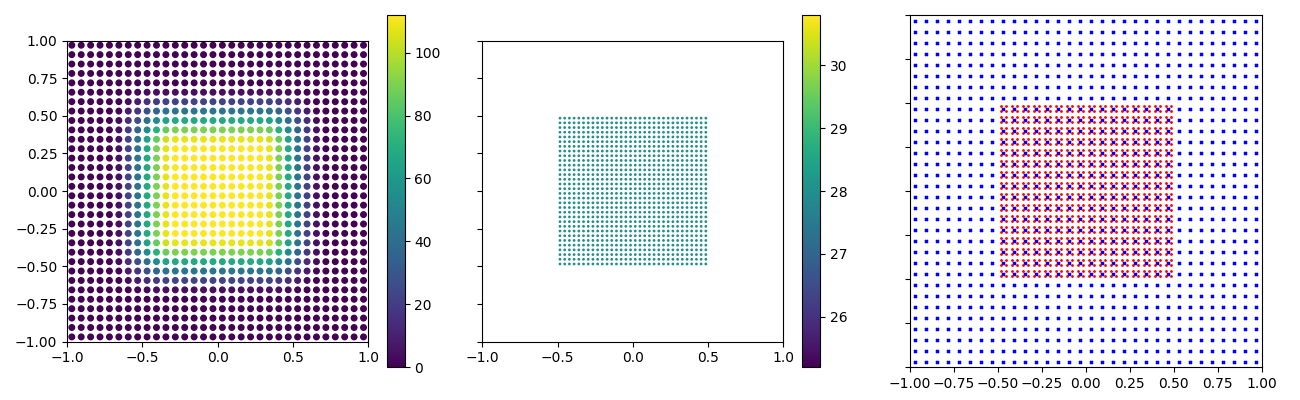

In [7]:
from torchCompactRadius.neighborhood import neighborSearchExisting
i2, j2 = neighborSearchExisting(pointCloudX, hashMap = compactHashMap, mode = 'symmetric', searchRadius = 1, variant = 'cpp', verbose = False)

print(i.shape, i2.shape)
print(j.shape, j2.shape)

jj2, numNeighborsJ2 = countUniqueEntries(j2, y)
ii2, numNeighborsI2 = countUniqueEntries(i2, x)

fig, ax = plt.subplots(1, 3, figsize = (13, 4), squeeze=False, sharey = True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)

sc = ax[0,0].scatter(x[:,0], x[:,1], cmap = 'viridis', c= numNeighborsI2, s = 16)
plt.colorbar(sc, ax = ax[0,0])

sc = ax[0,1].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ2, s = 1)
plt.colorbar(sc, ax = ax[0,1])

sc = ax[0,2].scatter(x[:,0], x[:,1], c = 'blue', marker = 'x', s = 4)
sc = ax[0,2].scatter(y[:,0], y[:,1], c = 'red', marker = 'o', s = 1)


fig.tight_layout()